## 1. 문제 정의
자전거 대여량 예측하기

## 2. 데이터 읽어오기
### * 캐글에서 받게되는 파일의 구성
- train.csv - 예측 모델을 만들기 위해 사용하는 학습셋
- test.csv - 예측 모델을 이용하여 예측할 탑승객 정보가 담긴 테스트셋
- sampleSubmission.csv - 제출시 사용할 수 있는 csv 파일

In [1]:
import pandas as pd

train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])

## 3. 데이터 확인

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import seaborn as sns

from scipy import stats

In [3]:
train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [4]:
test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


## 4. Feature engineering

In [5]:
for data in train, test:
    print('Old shape:', data.shape, end = '\t-> ')
    data["year"] = data["datetime"].dt.year
    data["month"] = data["datetime"].dt.month    
    data["hour"] = data["datetime"].dt.hour
    data["dayofweek"] = data["datetime"].dt.dayofweek
    print('New shape:', data.shape)

Old shape: (10886, 12)	-> New shape: (10886, 16)
Old shape: (6493, 9)	-> New shape: (6493, 13)


### 범주형 feature의 type을 category로 변경

In [6]:
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    for data in train, test:
        data[var] = data[var].astype("category")

## 5. Modeling

### 종속 변수와 독립변수 설정

In [7]:
X_features = ["season", "weather", "temp", "atemp", "humidity", 
                 "year", "hour", "dayofweek", "holiday", "workingday"]
X_train = train[X_features]
X_test  = test [X_features]
Y_train = train['count']

### 점수 기준

\begin{equation*}
RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log (p_i + 1) - \log (a_i + 1))^2}
\end{equation*}

In [8]:
from sklearn.metrics import make_scorer

def getRMSLE(p, a):
    p = np.array(p) # predicted values
    a = np.array(a) # actual values
    
    return np.sqrt(((np.log(p+1) - np.log(a+1))**2).mean())

rmsle_scorer = make_scorer(getRMSLE)

### Linear regression 적용

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept = True)
model.fit(X_train, Y_train)
predictions_train = model.predict(X_train)
predictions_train

array([-72.78152352, -67.85808278, -60.01261659, ..., 296.67105314,
       310.73925113, 303.2093096 ])

In [10]:
getRMSLE(predictions_train, Y_train)

c:\users\sigel\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


nan

### Random forest regression 적용

In [11]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, n_jobs = -1, random_state = 0)
model.fit(X_train, Y_train)
predictions_train = model.predict(X_train)  # 학습 데이터에 대한 예측값
predictions_test  = model.predict(X_test)   # test 데이터에 대한 예측값
predictions_train

array([ 19.57,  33.21,  27.36, ..., 179.81, 139.34, 103.05])

In [12]:
getRMSLE(predictions_train, Y_train)

0.14828029172603371

### 교차검증

In [13]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

def getScore(model):    
    score = cross_val_score(model, X_train, 
                            Y_train, cv=k_fold, n_jobs=1, scoring=rmsle_scorer)
    return score

In [14]:
scores = pd.DataFrame([getScore(model)], index = ['RF'])

In [15]:
score = scores.mean(axis = 1)
score

RF    0.329346
dtype: float64

### 학습 및 예측

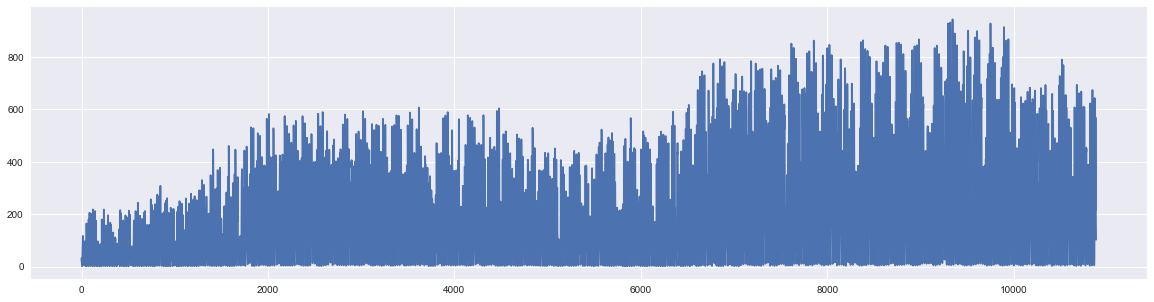

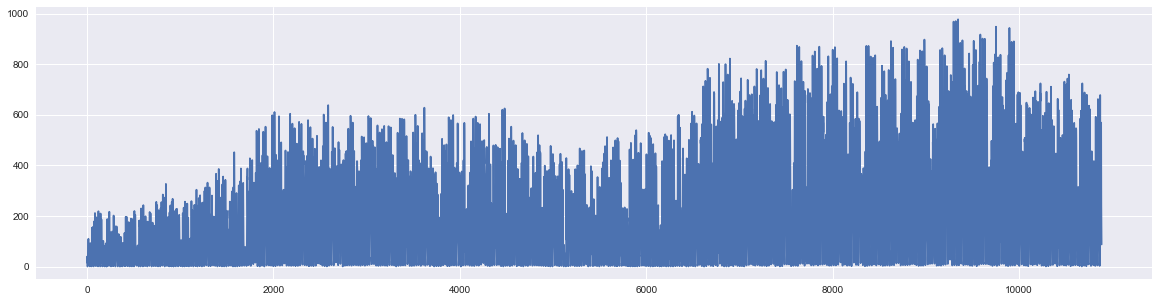

In [16]:
# 학습 데이터에 대한 실제 Y와 예측된 Y 비교
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (20, 5)); plt.plot(predictions_train, label = 'Predicted'); plt.show()
plt.figure(figsize = (20, 5)); plt.plot(Y_train,           label = 'Original'); plt.show()

[Text(0.5,1,'test')]

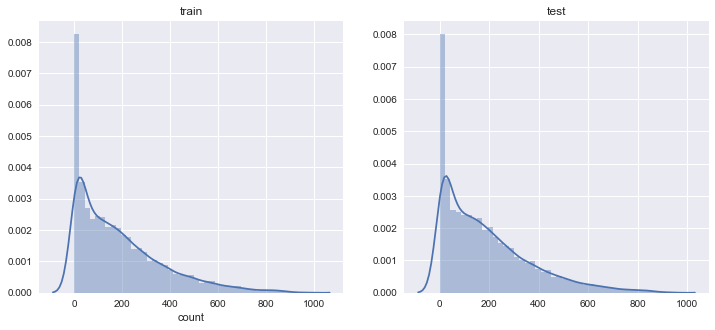

In [17]:
# 학습 데이터의 실제 Y와 테스트 데이터의 예측된 Y의 분포 비교
fig,axes= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(Y_train,          ax=axes[0]); axes[0].set(title="train")
sns.distplot(predictions_train,ax=axes[1]); axes[1].set(title="test")

In [18]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission["count"] = predictions_test
submission.to_csv("data/submission(%.5f).csv" % score, index=False)